# Natural Language Processing - Wikipedians Search

The three parts of this project are:
- Part 1: Use a traditional dataset in a CSV file
- Part 2: Use the Wikipedia API to directly access content on Wikipedia
- Part 3: Make your notebook interactive

# Part 1: Natural Language Processing with TextBlob and Text Representation

## Setup and Imports

In [53]:
%%capture
%pip install -U textblob wikipedia beautifulsoup4
!python -m textblob.download_corpora

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import wikipedia
from bs4 import BeautifulSoup
from textblob import TextBlob, Word, Blobber
from ipywidgets import widgets

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

## Load the CSV file

In [54]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.5-NLP/Data/NLP.csv"
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
print(df.head())
print(df.shape)


                                                 URI                 name  \
0        <http://dbpedia.org/resource/Digby_Morrell>        Digby Morrell   
1       <http://dbpedia.org/resource/Alfred_J._Lewy>       Alfred J. Lewy   
2        <http://dbpedia.org/resource/Harpdog_Brown>        Harpdog Brown   
3  <http://dbpedia.org/resource/Franz_Rottensteiner>  Franz Rottensteiner   
4               <http://dbpedia.org/resource/G-Enka>               G-Enka   

                                                text  
0  digby morrell born 10 october 1979 is a former...  
1  alfred j lewy aka sandy lewy graduated from un...  
2  harpdog brown is a singer and harmonica player...  
3  franz rottensteiner born in waidmannsfeld lowe...  
4  henry krvits born 30 december 1974 in tallinn ...  
(42786, 3)


## Clean and preprocess the data

In [69]:
  df['name'] = df['name'].str.lower()
  df['name'] = df['name'].str.replace(r'[^\w\s]', '', regex=True)
  df['text'] = df['text'].str.lower()
  df['text'] = df['text'].str.replace(r'[^\w\s]', '', regex=True)

## Create a TF-IDF vectorizer and transform the data

In [56]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['text'])

## Implement the K-Nearest Neighbors algorithm

In [57]:
nn = NearestNeighbors(n_neighbors=11, metric='cosine')
nn.fit(X)

NearestNeighbors(metric='cosine', n_neighbors=11)

## Create a function to find nearest neighbors and sentiment

In [58]:
def find_nearest_neighbors_and_sentiment(person_name):
    # Find the index of the person
    person_index = df[df['name'] == person_name].index[0]

    # Get the nearest neighbors
    distances, indices = nn.kneighbors(X[person_index].reshape(1, -1))

    # Get the names of the nearest neighbors (excluding the first person)
    nearest_neighbors = df.iloc[indices[0][1:]]['name'].tolist()

    # Calculate sentiment for the person
    person_text = df.loc[person_index, 'text']
    sentiment = TextBlob(person_text).sentiment

    return nearest_neighbors, sentiment

## Get nearest nearest neighbors and sentiment

In [59]:
x = 5000

person_name = df['name'].iloc[x]  # choose a person
nearest_neighbors, sentiment = find_nearest_neighbors_and_sentiment(person_name)

print(f"Nearest neighbors to {person_name}:")
for neighbor in nearest_neighbors:
    print(f"- {neighbor}")

print(f"\nSentiment of {person_name}'s text:")
print(f"Polarity: {sentiment.polarity}")
print(f"Subjectivity: {sentiment.subjectivity}")

Nearest neighbors to Donne Trotter:
- Thomas L. Kilbride
- Marvin E. Aspen
- Kimberly A. Lightford
- John W. Darrah
- Hiram Monserrate
- James G. Carr
- Jim Waring
- Samuel H. Young
- Todd Sieben
- Thomas W. Ewing

Sentiment of Donne Trotter's text:
Polarity: 0.007688688123470734
Subjectivity: 0.31977225672877846


## Perform dimensionality reduction using TruncatedSVD

In [60]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)

# Part 2: Wikipedia API Integration

## Function to retrieve Wikipedia content

In [62]:
def clean_text(text):
    text = text.lower()
    words = text.split()
    singularized_words = [Word(word).singularize() for word in words]
    return ' '.join(singularized_words)

## Function to analyze Wikipedia content

In [63]:
def get_wikipedia_content(person_name):
    max_attempts = 5
    for attempt in range(max_attempts):
        try:
            page = wikipedia.page(person_name)
            return page.content
        except wikipedia.exceptions.DisambiguationError as e:
            options = e.options
            if not options:
                print(f"No suitable options found for {person_name}")
                return None

            # Try each option in order
            for option in options:
                try:
                    page = wikipedia.page(option)
                    return page.content
                except (wikipedia.exceptions.PageError, wikipedia.exceptions.DisambiguationError):
                    continue

            print(f"All disambiguation options exhausted for {person_name}")
            return None

        except wikipedia.exceptions.PageError:
            print(f"No Wikipedia page found for {person_name}")
            return None

        except Exception as e:
            print(f"An error occurred while fetching Wikipedia page for {person_name}: {str(e)}")
            time.sleep(1)  # Add a delay to avoid hitting API rate limits

    print(f"Max attempts reached for {person_name}")
    return None

## use the function to analyze Wikipedia content for a specific person and nearest neighbors

In [64]:
main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

if main_content is not None:
    print(f"\nBoW Ranking:")
    for i, neighbor in enumerate(bow_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")

    print("\nTF-IDF Ranking:")
    for i, neighbor in enumerate(tfidf_wikipedia_ranking):
        print(f"{i+1}. {neighbor}")
else:
    # print("No suitable Wikipedia page found for the main person.")

TF-IDF Matrix shape: (11, 1917)
TF-IDF Similarity shape: (1, 10)
TF-IDF Similarity values: [[0.1132367  0.12034489 0.16161459 0.13463405 0.10020284 0.1059604
  0.13811382 0.09668855 0.1328839  0.13215724]]

BoW Ranking:
1. Kimberly A. Lightford
2. Todd Sieben
3. John W. Darrah
4. Thomas W. Ewing
5. Thomas L. Kilbride
6. Jim Waring
7. James G. Carr
8. Samuel H. Young
9. Marvin E. Aspen
10. Hiram Monserrate

TF-IDF Ranking:
1. Kimberly A. Lightford
2. Jim Waring
3. John W. Darrah
4. Todd Sieben
5. Thomas W. Ewing
6. Marvin E. Aspen
7. Thomas L. Kilbride
8. James G. Carr
9. Hiram Monserrate
10. Samuel H. Young


# Part 3: Visualization

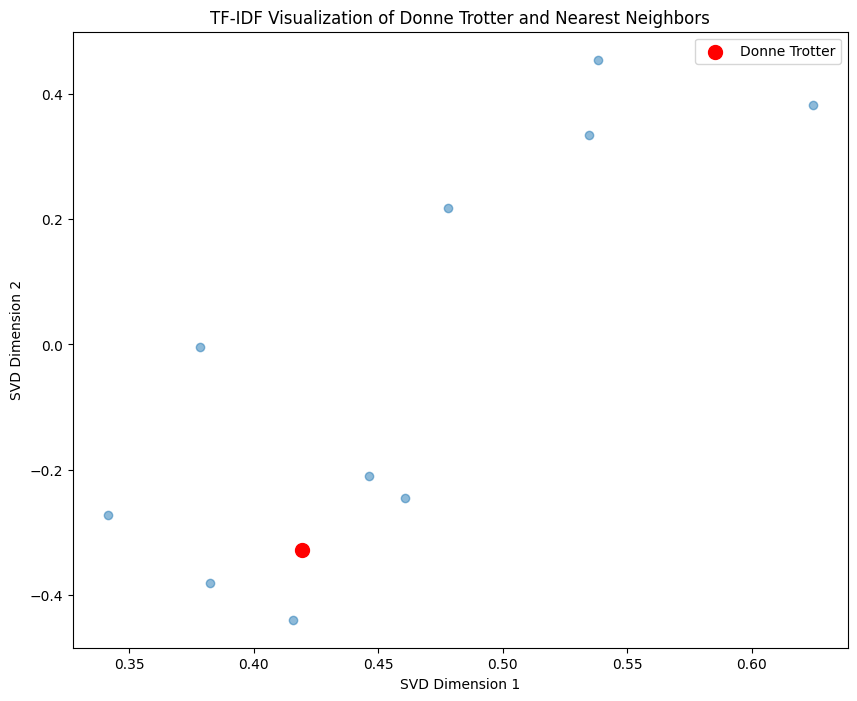

In [70]:
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(tfidf_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(X_svd[1:, 0], X_svd[1:, 1], alpha=0.5)
plt.scatter(X_svd[0, 0], X_svd[0, 1], color='red', s=100, label=person_name)
plt.title(f"TF-IDF Visualization of {person_name} and Nearest Neighbors")
plt.xlabel("SVD Dimension 1")
plt.ylabel("SVD Dimension 2")
plt.legend()
plt.show()

## Interactive Text Analysis

In [66]:
# Create a text box for input
text_box = widgets.Text(value='', placeholder='Enter a name or index', description='Person Name/Index:', disabled=False)

# Create a button to trigger the analysis
button = widgets.Button(description='Run Analysis')

# Create a display area for the output
output = widgets.Output()


## Calculate and display Analysis of person_name, nearest_neighbors, and sentiment comparison

In [67]:
def run_analysis(b):
    with output:
        output.clear_output()
        input_value = text_box.value

        # Check if input is empty
        if not input_value.strip():
            print("Please enter a name or index.")
            return

        # Check if input is a number
        if input_value.isdigit():
            x = int(input_value)
            person_name = df['name'].iloc[x]  # choose a person
        else:
            # Search for the name in the DataFrame
            person_name = input_value.lower()
            matching_index = df[df['name'] == person_name].index

            if len(matching_index) > 0:
                x = matching_index[0]
            else:
                print(f"No match found for {input_value}")
                return

        nearest_neighbors, sentiment = find_nearest_neighbors_and_sentiment(person_name)

        print(f"Nearest neighbors to {person_name}:")
        for neighbor in nearest_neighbors:
            print(f"- {neighbor}")

        print(f"\nSentiment of {person_name}'s text:")
        print(f"Polarity: {sentiment.polarity}")
        print(f"Subjectivity: {sentiment.subjectivity}")

        # Run the rest of analysis here
        main_content, bow_wikipedia_ranking, tfidf_wikipedia_ranking, tfidf_matrix = analyze_wikipedia_content(person_name, nearest_neighbors)

        if main_content is not None:
            print(f"\nBoW Ranking:")
            for i, neighbor in enumerate(bow_wikipedia_ranking):
                print(f"{i+1}. {neighbor}")

            print("\nTF-IDF Ranking:")
            for i, neighbor in enumerate(tfidf_wikipedia_ranking):
                print(f"{i+1}. {neighbor}")

            # Calculate and print main sentiment
            main_sentiment = TextBlob(main_content).sentiment
            print(f"\nSentiment of {person_name}'s Wikipedia page:")
            print(f"Polarity: {main_sentiment.polarity}")
            print(f"Subjectivity: {main_sentiment.subjectivity}")

            # Print out the Wikipedia article
            print(f"\nWikipedia article for {person_name}:")
            print(main_content[::])

            # Compare rankings only if the index is 5000
            if x == 5000:
                original_ranking = nearest_neighbors
                print("\nComparison of rankings:")
                for i, original_neighbor in enumerate(original_ranking):
                    if original_neighbor in bow_wikipedia_ranking:
                        bow_rank = bow_wikipedia_ranking.index(original_neighbor) + 1
                        print(f"{original_neighbor}: Original rank {i+1}, BoW rank {bow_rank}")
                    else:
                        print(f"{original_neighbor}: Original rank {i+1}, Not found in BoW ranking")

                    if original_neighbor in tfidf_wikipedia_ranking:
                        tfidf_rank = tfidf_wikipedia_ranking.index(original_neighbor) + 1
                        print(f"{original_neighbor}: Original rank {i+1}, TF-IDF rank {tfidf_rank}")
                    else:
                        print(f"{original_neighbor}: Original rank {i+1}, Not found in TF-IDF ranking")
        else:
            print("No suitable Wikipedia page found for the main person.")

# Keep the rest of your code the same
button = widgets.Button(description='Run Analysis')
button.on_click(run_analysis)

display(text_box)
display(button)
display(output)


Text(value='', description='Person Name/Index:', placeholder='Enter a name or index')

Button(description='Run Analysis', style=ButtonStyle())

Output()